In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot

import re
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from datetime import datetime
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes 
from lifelines import CoxPHFitter

In [2]:
df = pd.read_excel('Cancer patient data.xlsx')
df.shape

(8468, 14)

## 1. Clean the data

#### 1.1 Remove all patients who were diagnosed after 8/25/16.

In [3]:
df.drop(df[df['LUNG DT'] > '2016/08/25'].index, inplace = True)
df.drop(df[df['PANCREAS_DT'] > '2016/08/25'].index, inplace = True)
df.drop(df[df['THYROID_DT'] > '2016/08/25'].index, inplace = True)
df.drop(df[df['COLORECTAL_DT'] > '2016/08/25'].index, inplace = True)
df.drop(df[df['MELANOMA_DT'] > '2016/08/25'].index, inplace = True)
# 8463
df.shape

(8463, 14)

#### 1.2 Keep patients who died after 8/25/16 (you need to censor this data).

In [4]:
df.loc[df.DEATH_DATE_off > '2016/08/25', 'DEATH_DATE_off'] = np.nan
# 8463
df.shape

(8463, 14)

#### 1.3 Remove all patients who do not have a diagnosis date.

In [5]:
# check how many cancers one patient has 
df['check'] = df.LUNG + df.PANCREAS + df.THYROID + df.COLORECTAL + df.MELANOMA
df.drop(df[df['check'] == 0].index, inplace = True)
# 4152
df.shape

(4152, 15)

#### 1.4 Categorize race into White, African-American, Asian/Mideast-Indian, and Others.

In [6]:
# split the original race column to two independant columns
df[['first_race','second_race']] = df.race.str.split('/',expand=True,)

# 111 
Asian = df[df['first_race'] == 'Asian']
# 111, same as Asian 
Mid = df[df['second_race'] == 'Mideast Indian']
tf = Asian['race'] == 'Asian/Mideast Indian'
# 111, same as Asian.shape, which means that the race indicator for Asian/Mideast Indian is consistant
tf[tf==True].count().sum()

# 818
African = df[df['first_race'] == 'Black']
# 818, same as African.shape 
Af = df[df['second_race'] == 'African-American']

# 2683
White = df[df['first_race'] == 'White']

# Rename original race column 
df['race'] = df['race'].replace(['Black/African-American'],'African-American')
df['race'] = df['race'].replace(['Asian/Mideast Indian'],'Asian/Mideast-Indian')

race_col = ['White', 'African-American', 'Asian/Mideast-Indian']
df.loc[(~df.race.isin(race_col)),'race']= 'Others'

df = df.iloc[:, :-2]

## 2. Calculate the age of each patient at the time of cancer diagnosis.

In [7]:
df['min_DT'] = df[['LUNG DT','PANCREAS_DT','THYROID_DT','COLORECTAL_DT','MELANOMA_DT']].min(axis=1)
df['max_DT'] = df[['LUNG DT','PANCREAS_DT','THYROID_DT','COLORECTAL_DT','MELANOMA_DT']].max(axis=1)

# create a 'dead' column indicating whether the patient is dead or not (0: not dead, 1: dead)
df['dead'] = np.where(df.DEATH_DATE_off.notnull(), 1, 0)

live = df.loc[df['dead'] == 0]
print('live num:', live.shape[0])
dead = df.loc[df['dead'] == 1]
print('dead num:', dead.shape[0])

live['diagnosis_days_min'] = (datetime(2016,8,25) - live['min_DT']).astype('timedelta64[D]')
live['diagnosis_years_min'] = (datetime(2016,8,25) - live['min_DT']).astype('timedelta64[Y]')
live['diagnosis_days_max'] = (datetime(2016,8,25) - live['max_DT']).astype('timedelta64[D]')
live['diagnosis_years_max'] = (datetime(2016,8,25) - live['max_DT']).astype('timedelta64[Y]')

dead['diagnosis_days_min'] = (dead['DEATH_DATE_off'] - dead['min_DT']).astype('timedelta64[D]')
dead['diagnosis_years_min'] = (dead['DEATH_DATE_off'] - dead['min_DT']).astype('timedelta64[Y]')
dead['diagnosis_days_max'] = (dead['DEATH_DATE_off'] - dead['max_DT']).astype('timedelta64[D]')
dead['diagnosis_years_max'] = (dead['DEATH_DATE_off'] - dead['max_DT']).astype('timedelta64[Y]')

df = pd.concat([live,dead])
print('final df:',df.shape[0])

live num: 3855
dead num: 297
final df: 4152


In [8]:
df_x = df.sort_values(by=['diagnosis_days_min'])
df_x.head(1)
# change one patient who has negative diagnosis_days_ to 0
df.loc[df.diagnosis_days_min < 0, 'DEATH_DATE_off'] = datetime(2016,8,25)
df.loc[df.diagnosis_days_min < 0, 'LUNG DT'] = datetime(2016,8,25)
df.loc[df.diagnosis_days_min < 0, 'min_DT'] = datetime(2016,8,25)
df.loc[df.diagnosis_days_min < 0, 'max_DT'] = datetime(2016,8,25)
df.loc[df.diagnosis_days_min < 0, 'diagnosis_years_min'] = 0
df.loc[df.diagnosis_days_min < 0, 'diagnosis_years_max'] = 0
df.loc[df.diagnosis_days_min < 0, 'diagnosis_days_max'] = 0
df.loc[df.diagnosis_days_min < 0, 'diagnosis_days_min'] = 0

## 3. Analyze survival rate by gender, race and age group for patients.

#### 3.0 Organize the data 

In [9]:
# add age group
df['age_min'] = (df['min_DT'] - df['BIRTH_DATE_off']).astype('timedelta64[Y]')
df['age_max'] = (df['max_DT'] - df['BIRTH_DATE_off']).astype('timedelta64[Y]')

# set 2014-12-21 kid's age to 1
df.loc[df.BIRTH_DATE_off == '2014-12-21', 'age_min'] = 1
df.loc[df.BIRTH_DATE_off == '2014-12-21', 'age_max'] = 1

category1 = pd.cut(df.age_min,bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110, np.inf],
                  labels=['<=10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', 
                          '81-90', '91-100','101-110'])
df.insert(3,'age_min_Group',category1)

category2 = pd.cut(df.age_max,bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 110, np.inf],
                  labels=['<=10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', 
                          '81-90', '91-100','101-110'])
df.insert(4,'age_max_Group',category2)

# check nan
print(df.isnull().sum())
df[df["age_min_Group"].isnull()]

# drop nan : only 4148 data left 
df1 = df.dropna(subset=['min_DT'])

BIRTH_DATE_off            0
DEATH_DATE_off         3855
sex                       0
age_min_Group             4
age_max_Group             4
race                      0
LUNG                      0
PANCREAS                  0
THYROID                   0
COLORECTAL                0
MELANOMA                  0
LUNG DT                2669
PANCREAS_DT            3494
THYROID_DT             3408
COLORECTAL_DT          3206
MELANOMA_DT            3806
check                     0
min_DT                    4
max_DT                    4
dead                      0
diagnosis_days_min        4
diagnosis_years_min       4
diagnosis_days_max        4
diagnosis_years_max       4
age_min                   4
age_max                   4
dtype: int64


In [10]:
# only four patients belong to different age groups 
df1.loc[~(df1['age_min_Group'] == df1['age_max_Group'])]

,BIRTH_DATE_off,DEATH_DATE_off,sex,age_min_Group,age_max_Group,race,LUNG,PANCREAS,THYROID,COLORECTAL,...,check,min_DT,max_DT,dead,diagnosis_days_min,diagnosis_years_min,diagnosis_days_max,diagnosis_years_max,age_min,age_max
308,1954-04-20,NaT,Female,51-60,61-70,African-American,0,0,1,1,...,2,2010-12-04,2015-05-06,0,2091.0,5.0,477.0,1.0,56.0,61.0
3513,1944-03-27,NaT,Male,61-70,71-80,White,1,1,0,0,...,2,2013-06-13,2015-10-21,0,1169.0,3.0,309.0,0.0,69.0,71.0
5679,1943-09-25,NaT,Male,51-60,61-70,White,1,0,0,0,...,2,2002-02-24,2013-02-12,0,5296.0,14.0,1290.0,3.0,58.0,69.0
6549,1952-07-14,NaT,Male,51-60,61-70,African-American,1,0,0,1,...,2,2013-06-17,2014-03-18,0,1165.0,3.0,891.0,2.0,60.0,61.0


In [11]:
cat_cols= ['sex','age_min_Group','race']
for i in cat_cols:
    print('Column Name: ',i)
    print(df1[i].value_counts())
    print('-----------------------------')

Column Name:  sex
Female    2190
Male      1958
Name: sex, dtype: int64
-----------------------------
Column Name:  age_min_Group
61-70      1213
51-60       931
71-80       814
41-50       473
81-90       274
31-40       241
21-30       116
11-20        50
91-100       29
<=10          7
101-110       0
Name: age_min_Group, dtype: int64
-----------------------------
Column Name:  race
White                   2815
African-American         956
Others                   260
Asian/Mideast-Indian     117
Name: race, dtype: int64
-----------------------------


#### 3.1 By gender 

Text(0.5, 1.0, 'KMF_gender')

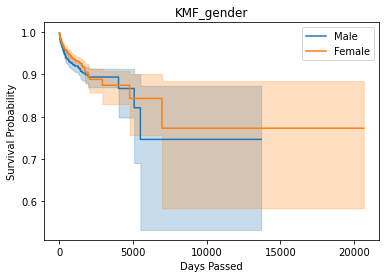

In [14]:
kmf_gender = KaplanMeierFitter() 

T = df1['diagnosis_days_min']     
E = df1['dead']                

sex_group = df1['sex']            
male = (sex_group == 'Male')  
female = (sex_group == 'Female')       

kmf_gender.fit(T[male], E[male], label='Male')    
ax1 = kmf_gender.plot()

kmf_gender.fit(T[female], E[female], label='Female')         
ax2 = kmf_gender.plot(ax=ax1)

plt.xlabel('Days Passed')
plt.ylabel('Survival Probability')
plt.title('KMF_gender')

#### 3.2 By race

Text(0.5, 1.0, 'KMF_race')

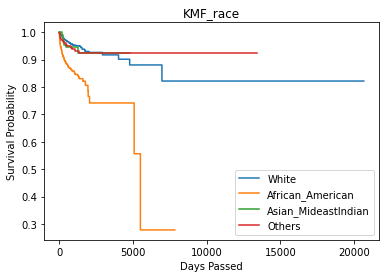

In [15]:
kmf_race = KaplanMeierFitter() 

race_group = df1['race']            
White = (race_group == 'White')  
African_American = (race_group == 'African-American')
Asian_MideastIndian = (race_group == 'Asian/Mideast-Indian')
Others = (race_group == 'Others')

kmf_race.fit(T[White], E[White], label='White')    
ax1 = kmf_race.plot(ci_show=False)

kmf_race.fit(T[African_American], E[African_American], label='African_American')    
ax2 = kmf_race.plot(ax=ax1,ci_show=False)

kmf_race.fit(T[Asian_MideastIndian], E[Asian_MideastIndian], label='Asian_MideastIndian')    
ax3 = kmf_race.plot(ax=ax2,ci_show=False)

kmf_race.fit(T[Others], E[Others], label='Others')    
ax4 = kmf_race.plot(ax=ax3,ci_show=False)

plt.xlabel('Days Passed')
plt.ylabel('Survival Probability')
plt.title('KMF_race')

#### 3.3 By age group 

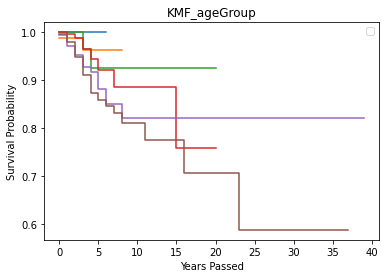

In [15]:
kmf_age = KaplanMeierFitter() 

age_group = df1['age_Group'] 

le10 = (age_group == '<=10')  
_11to20 = (age_group == '11-20')
_21to30 = (age_group == '21-30')
_31to40 = (age_group == '31-40')
_41to50 = (age_group == '41-50')
_51to60 = (age_group == '51-60')
_61to70 = (age_group == '61-70')
_61to70 = (age_group == '71-80')
_61to70 = (age_group == '81-90')
_61to70 = (age_group == '91-100')

kmf_age.fit(T[le10], E[le10], label='<=10')    
ax = kmf_age.plot(ci_show=False,ci_legend=True)

kmf_age.fit(T[_11to20], E[_11to20], label='_11to20')    
ax1 = kmf_age.plot(ci_show=False,ci_legend=True)

kmf_age.fit(T[_21to30], E[_21to30], label='_21to30')    
ax2 = kmf_age.plot(ax=ax1,ci_show=False,ci_legend=True)

kmf_age.fit(T[_31to40], E[_31to40], label='_31to40')    
ax3 = kmf_age.plot(ax=ax2,ci_show=False,ci_legend=True)

kmf_age.fit(T[_41to50], E[_41to50], label='_41to50')    
ax4 = kmf_age.plot(ax=ax3,ci_show=False,ci_legend=True)

kmf_age.fit(T[_51to60], E[_51to60], label='_51to60')    
ax5 = kmf_age.plot(ax=ax4,ci_show=False,ci_legend=True)

kmf_age.fit(T[_61to70], E[_61to70], label='_61to70')    
ax6 = kmf_age.plot(ax=ax5,ci_show=False,ci_legend=True)


plt.xlabel('Years Passed')
plt.ylabel('Survival Probability')
plt.title('KMF_ageGroup')
legend = plt.legend([ax1, ax2, ax3, ax4, ax5, ax6], ['_11to20','_21to30','_31to40','_41to50','_51to60','_61to70'])

## 4. Questions.

In [16]:
print(df1.shape[0])
df1.columns

4148


Index(['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'age_min_Group',
       'age_max_Group', 'race', 'LUNG', 'PANCREAS', 'THYROID', 'COLORECTAL',
       'MELANOMA', 'LUNG DT', 'PANCREAS_DT', 'THYROID_DT', 'COLORECTAL_DT',
       'MELANOMA_DT', 'check', 'min_DT', 'max_DT', 'dead',
       'diagnosis_days_min', 'diagnosis_years_min', 'diagnosis_days_max',
       'diagnosis_years_max', 'age_min', 'age_max'],
      dtype='object')

### 4.1 which cancer has the highest survival for this cohort?

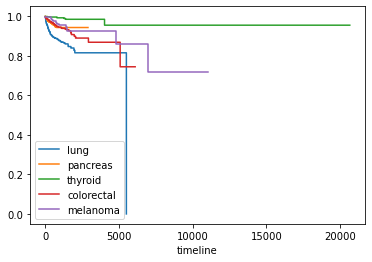

In [17]:
lung = df1[df1['LUNG'] == 1]
pancreas = df1[df1['PANCREAS'] == 1]
thyroid = df1[df1['THYROID'] == 1]
colorectal = df1[df1['COLORECTAL'] == 1]
melanoma = df1[df1['MELANOMA'] == 1]

kmf_l = KaplanMeierFitter() 
kmf_p = KaplanMeierFitter() 
kmf_t = KaplanMeierFitter() 
kmf_c = KaplanMeierFitter() 
kmf_m = KaplanMeierFitter() 

kmf_l.fit(durations = lung['diagnosis_days_min'], event_observed = lung['dead'], label = 'lung')
kmf_p.fit(durations = pancreas['diagnosis_days_min'], event_observed = pancreas['dead'], label = 'pancreas')
kmf_t.fit(durations = thyroid['diagnosis_days_min'], event_observed = thyroid['dead'], label = 'thyroid')
kmf_c.fit(durations = colorectal['diagnosis_days_min'], event_observed = colorectal['dead'], label = 'colorectal')
kmf_m.fit(durations = melanoma['diagnosis_days_min'], event_observed = melanoma['dead'], label = 'melanoma')

kmf_l.plot(ci_show=False)
kmf_p.plot(ci_show=False)
kmf_t.plot(ci_show=False)
kmf_c.plot(ci_show=False)
kmf_m.plot(ci_show=False)

In [18]:
print('thyroid:', kmf_t.predict(10000))
print('pancreas:', kmf_p.predict(2500))

thyroid: 0.9547615361309725
pancreas: 0.9429699743228026


In [19]:
print('Thyroid cancer has the highest survival.')

Thyroid cancer has the highest survival.


### 4.2 which cancer has the lowest survival for this cohort?

In [20]:
print('Lung cancer has the lowest survival.')
print('The lung cancer drop to 0 because the last patient with the longest days survived died rather than censored.')

Lung cancer has the lowest survival.
The lung cancer drop to 0 because the last patient with the longest days survived died rather than censored.


### 4.3 how many patients had 2 cancer diagnosis?

In [21]:
patients_w2cancers = df.loc[(df['check'] == 2)]
# 29 patients have 2 cancers 
print(patients_w2cancers.shape[0], 'patients had 2 cancers diagnosis.')

29 patients had 2 cancers diagnosis.


### 4.4 which age group has the lowest survival after 400 days since cancer diagnosis?

In [22]:
le10 = df1[df1['age_min_Group'] == '<=10']
_11to20 = df1[df1['age_min_Group'] == '11-20']
_21to30 = df1[df1['age_min_Group'] == '21-30']
_31to40 = df1[df1['age_min_Group'] == '31-40']
_41to50 = df1[df1['age_min_Group'] == '41-50']
_51to60 = df1[df1['age_min_Group'] == '51-60']
_61to70 = df1[df1['age_min_Group'] == '61-70']
_71to80 = df1[df1['age_min_Group'] == '71-80']
_81to90 = df1[df1['age_min_Group'] == '81-90']
_91to100 = df1[df1['age_min_Group'] == '91-100']

kmf_0 = KaplanMeierFitter() 
kmf_1 = KaplanMeierFitter() 
kmf_2 = KaplanMeierFitter() 
kmf_3 = KaplanMeierFitter() 
kmf_4 = KaplanMeierFitter() 
kmf_5 = KaplanMeierFitter() 
kmf_6 = KaplanMeierFitter() 
kmf_7 = KaplanMeierFitter() 
kmf_8 = KaplanMeierFitter() 
kmf_9 = KaplanMeierFitter() 

kmf_0.fit(durations = le10['diagnosis_days_min'], event_observed = le10['dead'], label = 'le10')
kmf_1.fit(durations = _11to20['diagnosis_days_min'], event_observed = _11to20['dead'], label = '_11to20')
kmf_2.fit(durations = _21to30['diagnosis_days_min'], event_observed = _21to30['dead'], label = '_21to30')
kmf_3.fit(durations = _31to40['diagnosis_days_min'], event_observed = _31to40['dead'], label = '_31to40')
kmf_4.fit(durations = _41to50['diagnosis_days_min'], event_observed = _41to50['dead'], label = '_41to50')
kmf_5.fit(durations = _51to60['diagnosis_days_min'], event_observed = _51to60['dead'], label = '_51to60')
kmf_6.fit(durations = _61to70['diagnosis_days_min'], event_observed = _61to70['dead'], label = '_61to70')
kmf_7.fit(durations = _71to80['diagnosis_days_min'], event_observed = _71to80['dead'], label = '_71to80')
kmf_8.fit(durations = _81to90['diagnosis_days_min'], event_observed = _81to90['dead'], label = '_81to90')
kmf_9.fit(durations = _91to100['diagnosis_days_min'], event_observed = _91to100['dead'], label = '_91to100')

print(kmf_0.predict(400))
print(kmf_1.predict(400))
print(kmf_2.predict(400))
print(kmf_3.predict(400))
print(kmf_4.predict(400))
print(kmf_5.predict(400))
print(kmf_6.predict(400))
print(kmf_7.predict(400))
print(kmf_8.predict(400))
print(kmf_9.predict(400))

1.0
1.0
0.9913793103448278
0.9914656432748542
0.9849376524213672
0.9548117476224486
0.9517494266087191
0.9243922603790926
0.9344247786865005
0.7916041979010496


In [277]:
print('91-100 age group has the lowest survival after 400 days since cancer diagnosis.')

91-100 age group has the lowest survival after 400 days since cancer diagnosis.


### 4.5 what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [23]:
df_f_c = df1[(df1['sex'] == 'Female') & (df1['COLORECTAL'] == 1)]

df_f_c_live = df_f_c.loc[df_f_c['dead'] == 0]
print('live num:', df_f_c_live.shape[0])
df_f_c_dead = df_f_c.loc[df_f_c['dead'] == 1]
print('dead num:', df_f_c_dead.shape[0])

df_f_c_live['diagnosis_days_c'] = (datetime(2016,8,25) - df_f_c_live['COLORECTAL_DT']).astype('timedelta64[D]')
df_f_c_dead['diagnosis_days_c'] = (df_f_c_dead['DEATH_DATE_off'] - df_f_c_dead['COLORECTAL_DT']).astype('timedelta64[D]')

df_f_co = pd.concat([df_f_c_live,df_f_c_dead])
print('final df:',df_f_co.shape[0])

kmf_f_co = KaplanMeierFitter()  

kmf_f_co.fit(durations = df_f_co['diagnosis_days_c'], event_observed = df_f_co['dead'], label = 'f_colorectal')

print('The survival rate is:',kmf_f_co.predict(1000))

live num: 398
dead num: 25
final df: 423
The survival rate is: 0.9484362597817692


### 4.6 what is the survival rate for males with lung cancer after 300 days since diagnosis?

In [24]:
df_m_l = df1[(df1['sex'] == 'Male') & (df1['LUNG'] == 1)]

df_m_l_live = df_m_l.loc[df_m_l['dead'] == 0]
print('live num:', df_m_l_live.shape[0])
df_m_l_dead = df_m_l.loc[df_m_l['dead'] == 1]
print('dead num:', df_m_l_dead.shape[0])

df_m_l_live['diagnosis_days_l'] = (datetime(2016,8,25) - df_m_l_live['LUNG DT']).astype('timedelta64[D]')
df_m_l_dead['diagnosis_days_l'] = (df_m_l_dead['DEATH_DATE_off'] - df_m_l_dead['LUNG DT']).astype('timedelta64[D]')

df_m_lu = pd.concat([df_m_l_live,df_m_l_dead])
print('final df:',df_m_lu.shape[0])

kmf_m_lu = KaplanMeierFitter()  

kmf_m_lu.fit(durations = df_m_lu['diagnosis_days_l'], event_observed = df_m_lu['dead'], label = 'm_lung')

print('The survival rate is:',kmf_m_lu.predict(300))

live num: 623
dead num: 95
final df: 718
The survival rate is: 0.9149880203162795


### 4.7 what is the survival rate for females with melanoma cancer after 1200 days since diagnosis?

In [25]:
df_f_m = df1[(df1['sex'] == 'Female') & (df1['MELANOMA'] == 1)]

df_f_m_live = df_f_m.loc[df_f_m['dead'] == 0]
print('live num:', df_f_m_live.shape[0])
df_f_m_dead = df_f_m.loc[df_f_m['dead'] == 1]
print('dead num:', df_f_m_dead.shape[0])

df_f_m_live['diagnosis_days_m'] = (datetime(2016,8,25) - df_f_m_live['MELANOMA_DT']).astype('timedelta64[D]')
df_f_m_dead['diagnosis_days_m'] = (df_f_m_dead['DEATH_DATE_off'] - df_f_m_dead['MELANOMA_DT']).astype('timedelta64[D]')

df_f_me = pd.concat([df_f_m_live,df_f_m_dead])
print('final df:',df_f_me.shape[0])

kmf_f_me = KaplanMeierFitter()  

kmf_f_me.fit(durations = df_f_me['diagnosis_days_m'], event_observed = df_f_me['dead'], label = 'f_melanoma')

print('The survival rate is:',kmf_f_me.predict(1200))

live num: 152
dead num: 8
final df: 160
The survival rate is: 0.9587861344911673


### 4.8 what is the survival rate for males with thyroid cancer after 1500 days since diagnosis?

In [26]:
df_m_t = df1[(df1['sex'] == 'Male') & (df1['THYROID'] == 1)]

df_m_t_live = df_m_t.loc[df_m_t['dead'] == 0]
print('live num:', df_m_t_live.shape[0])
df_m_t_dead = df_m_t.loc[df_m_t['dead'] == 1]
print('dead num:', df_m_t_dead.shape[0])

df_m_t_live['diagnosis_days_t'] = (datetime(2016,8,25) - df_m_t_live['THYROID_DT']).astype('timedelta64[D]')
df_m_t_dead['diagnosis_days_t'] = (df_m_t_dead['DEATH_DATE_off'] - df_m_t_dead['THYROID_DT']).astype('timedelta64[D]')

df_m_th = pd.concat([df_m_t_live,df_m_t_dead])
print('final df:',df_m_th.shape[0])

kmf_m_th = KaplanMeierFitter()  

kmf_m_th.fit(durations = df_m_th['diagnosis_days_t'], event_observed = df_m_th['dead'], label = 'm_thyroid')

print('The survival rate is:',kmf_m_th.predict(1500))

live num: 200
dead num: 5
final df: 205
The survival rate is: 0.9723197357959752


### 4.9 what is the survival rate for males with pancreatic cancer after 2200 days since diagnosis?

In [27]:
df_m_p = df1[(df1['sex'] == 'Male') & (df1['PANCREAS'] == 1)]

df_m_p_live = df_m_p.loc[df_m_p['dead'] == 0]
print('live num:', df_m_p_live.shape[0])
df_m_p_dead = df_m_p.loc[df_m_p['dead'] == 1]
print('dead num:', df_m_p_dead.shape[0])

df_m_p_live['diagnosis_days_p'] = (datetime(2016,8,25) - df_m_p_live['PANCREAS_DT']).astype('timedelta64[D]')
df_m_p_dead['diagnosis_days_p'] = (df_m_p_dead['DEATH_DATE_off'] - df_m_p_dead['PANCREAS_DT']).astype('timedelta64[D]')

df_m_pa = pd.concat([df_m_p_live,df_m_p_dead])
print('final df:',df_m_pa.shape[0])

kmf_m_pa = KaplanMeierFitter()  

kmf_m_pa.fit(durations = df_m_pa['diagnosis_days_p'], event_observed = df_m_pa['dead'], label = 'm_pancreas')

print('The survival rate is:',kmf_m_pa.predict(2200))

live num: 326
dead num: 14
final df: 340
The survival rate is: 0.9526692572895107


### 4.10 what is the survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis?

In [28]:
African_American = df1[(df1['race'] == 'African-American') & df1['COLORECTAL'] == 1]

df_aa_c_live = African_American.loc[African_American['dead'] == 0]
print('live num:', df_aa_c_live.shape[0])
df_aa_c_dead = African_American.loc[African_American['dead'] == 1]
print('dead num:', df_aa_c_dead.shape[0])

df_aa_c_live['diagnosis_days_c'] = (datetime(2016,8,25) - df_aa_c_live['COLORECTAL_DT']).astype('timedelta64[D]')
df_aa_c_dead['diagnosis_days_c'] = (df_aa_c_dead['DEATH_DATE_off'] - df_aa_c_dead['COLORECTAL_DT']).astype('timedelta64[D]')

df_aa_co = pd.concat([df_aa_c_live,df_aa_c_dead])
print('final df:',df_aa_co.shape[0])

kmf_aa_co = KaplanMeierFitter()  

kmf_aa_co.fit(durations = df_aa_co['diagnosis_days_c'], event_observed = df_aa_co['dead'], label = 'African_American')

print('The survival rate is:',kmf_aa_co.predict(2000))

live num: 233
dead num: 30
final df: 263
The survival rate is: 0.7706150842786863


### 4.11 what is the survival rate for Whites with lung cancer after 1000 days since diagnosis?

In [29]:
White = df1[(df1['race'] == 'White') & df1['LUNG'] == 1]

df_w_l_live = White.loc[White['dead'] == 0]
print('live num:', df_w_l_live.shape[0])
df_w_l_dead = White.loc[White['dead'] == 1]
print('dead num:', df_w_l_dead.shape[0])

df_w_l_live['diagnosis_days_l'] = (datetime(2016,8,25) - df_w_l_live['LUNG DT']).astype('timedelta64[D]')
df_w_l_dead['diagnosis_days_l'] = (df_w_l_dead['DEATH_DATE_off'] - df_w_l_dead['LUNG DT']).astype('timedelta64[D]')

df_w_lu = pd.concat([df_w_l_live,df_w_l_dead])
print('final df:',df_w_lu.shape[0])

kmf_w_lu = KaplanMeierFitter()  

kmf_w_lu.fit(durations = df_w_lu['diagnosis_days_l'], event_observed = df_w_lu['dead'], label = 'White')

print('The survival rate is:',kmf_w_lu.predict(1000))

live num: 828
dead num: 82
final df: 910
The survival rate is: 0.9092859116518297


### 4.12 what is the survival rate for African-Americans with melanoma cancer after 2 years since diagnosis?

In [30]:
African_American_m = df1[(df1['race'] == 'African-American') & df1['MELANOMA'] == 1]

df_aa_m_live = African_American_m.loc[African_American_m['dead'] == 0]
print('live num:', df_aa_m_live.shape[0])
df_aa_m_dead = African_American_m.loc[African_American_m['dead'] == 1]
print('dead num:', df_aa_m_dead.shape[0])

df_aa_m_live['diagnosis_days_m'] = (datetime(2016,8,25) - df_aa_m_live['MELANOMA_DT']).astype('timedelta64[D]')
df_aa_m_dead['diagnosis_days_m'] = (df_aa_m_dead['DEATH_DATE_off'] - df_aa_m_dead['MELANOMA_DT']).astype('timedelta64[D]')

df_aa_me = pd.concat([df_aa_m_live,df_aa_m_dead])
print('final df:',df_aa_me.shape[0])

kmf_aa_me = KaplanMeierFitter()  

kmf_aa_me.fit(durations = df_aa_me['diagnosis_days_m'], event_observed = df_aa_me['dead'], label = 'African_American_m')

print('The survival rate is:',kmf_aa_me.predict(730))

live num: 12
dead num: 2
final df: 14
The survival rate is: 0.8253968253968252


### 4.13 what is the survival rate for Whites with pancreatic cancer after 3 years since diagnosis?

In [31]:
White_p = df1[(df1['race'] == 'White') & df1['PANCREAS'] == 1]

df_w_p_live = White_p.loc[White_p['dead'] == 0]
print('live num:', df_w_p_live.shape[0])
df_w_p_dead = White_p.loc[White_p['dead'] == 1]
print('dead num:', df_w_p_dead.shape[0])

df_w_p_live['diagnosis_days_p'] = (datetime(2016,8,25) - df_w_p_live['PANCREAS_DT']).astype('timedelta64[D]')
df_w_p_dead['diagnosis_days_p'] = (df_w_p_dead['DEATH_DATE_off'] - df_w_p_dead['PANCREAS_DT']).astype('timedelta64[D]')

df_w_pa = pd.concat([df_w_p_live,df_w_p_dead])
print('final df:',df_w_pa.shape[0])

kmf_w_pa = KaplanMeierFitter()  

kmf_w_pa.fit(durations = df_w_pa['diagnosis_days_p'], event_observed = df_w_pa['dead'], label = 'White_p')

print('The survival rate is:',kmf_w_pa.predict(1095))

live num: 431
dead num: 13
final df: 444
The survival rate is: 0.9653081799604994


In [32]:
kmf_m_papapa = KaplanMeierFitter()  

kmf_m_papapa.fit(durations = White_p['diagnosis_days_min'], event_observed = White_p['dead'], label = 'm_pancreas')

print('The survival rate is:',kmf_m_papapa.predict(1095))

The survival rate is: 0.9653763529000424


### 4.14 what is the survival rate for Asians with thyroid cancer after 1500 days since diagnosis?

In [33]:
Asian_Mideast_Indian_t = df1[(df1['race'] == 'Asian/Mideast-Indian') & (df1['THYROID']==1)]

df_am_t_live = Asian_Mideast_Indian_t.loc[Asian_Mideast_Indian_t['dead'] == 0]
print('live num:', df_am_t_live.shape[0])
df_am_t_dead = Asian_Mideast_Indian_t.loc[Asian_Mideast_Indian_t['dead'] == 1]
print('dead num:', df_am_t_dead.shape[0])

df_am_t_live['diagnosis_days_t'] = (datetime(2016,8,25) - df_am_t_live['THYROID_DT']).astype('timedelta64[D]')
df_am_t_dead['diagnosis_days_t'] = (df_am_t_dead['DEATH_DATE_off'] - df_am_t_dead['THYROID_DT']).astype('timedelta64[D]')

df_am_th = pd.concat([df_am_t_live,df_am_t_dead])
print('final df:',df_am_th.shape[0])

kmf_am_th = KaplanMeierFitter()  

kmf_am_th.fit(durations = df_am_th['diagnosis_days_t'], event_observed = df_am_th['dead'], label = 'Asian/Mideast-Indian_t')

print('The survival rate is:',kmf_am_th.predict(1500))

live num: 36
dead num: 1
final df: 37
The survival rate is: 0.9285714285714287


### 4.15 which age group has the lowest survival for colorectal cancer at the end of the study?

1.0


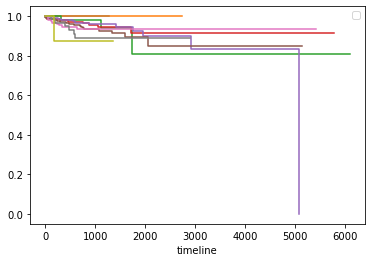

In [34]:
#le10 = df1[(df1['age_min_Group'] == '<=10') & (df1['COLORECTAL']==1)]
_11to20 = df1[(df1['age_min_Group'] == '11-20') & (df1['COLORECTAL']==1)]
_21to30 = df1[(df1['age_min_Group'] == '21-30') & (df1['COLORECTAL']==1)]
_31to40 = df1[(df1['age_min_Group'] == '31-40') & (df1['COLORECTAL']==1)]
_41to50 = df1[(df1['age_min_Group'] == '41-50') & (df1['COLORECTAL']==1)]
_51to60 = df1[(df1['age_min_Group'] == '51-60') & (df1['COLORECTAL']==1)]
_61to70 = df1[(df1['age_min_Group'] == '61-70') & (df1['COLORECTAL']==1)]
_71to80 = df1[(df1['age_min_Group'] == '71-80') & (df1['COLORECTAL']==1)]
_81to90 = df1[(df1['age_min_Group'] == '81-90') & (df1['COLORECTAL']==1)]
_91to100 = df1[(df1['age_min_Group'] == '91-100') & (df1['COLORECTAL']==1)]

#kmf_0 = KaplanMeierFitter() 
kmf_1 = KaplanMeierFitter() 
kmf_2 = KaplanMeierFitter() 
kmf_3 = KaplanMeierFitter() 
kmf_4 = KaplanMeierFitter() 
kmf_5 = KaplanMeierFitter() 
kmf_6 = KaplanMeierFitter() 
kmf_7 = KaplanMeierFitter() 
kmf_8 = KaplanMeierFitter() 
kmf_9 = KaplanMeierFitter() 

#kmf_0.fit(durations = le10['diagnosis_days_min'], event_observed = le10['dead'], label = 'le10')
kmf_1.fit(durations = _11to20['diagnosis_days_min'], event_observed = _11to20['dead'], label = '_11to20')
kmf_2.fit(durations = _21to30['diagnosis_days_min'], event_observed = _21to30['dead'], label = '_21to30')
kmf_3.fit(durations = _31to40['diagnosis_days_min'], event_observed = _31to40['dead'], label = '_31to40')
kmf_4.fit(durations = _41to50['diagnosis_days_min'], event_observed = _41to50['dead'], label = '_41to50')
kmf_5.fit(durations = _51to60['diagnosis_days_min'], event_observed = _51to60['dead'], label = '_51to60')
kmf_6.fit(durations = _61to70['diagnosis_days_min'], event_observed = _61to70['dead'], label = '_61to70')
kmf_7.fit(durations = _71to80['diagnosis_days_min'], event_observed = _71to80['dead'], label = '_71to80')
kmf_8.fit(durations = _81to90['diagnosis_days_min'], event_observed = _81to90['dead'], label = '_81to90')
kmf_9.fit(durations = _91to100['diagnosis_days_min'], event_observed = _91to100['dead'], label = '_91to100')

kmf_1.plot(ci_show=False)
kmf_2.plot(ci_show=False)
kmf_3.plot(ci_show=False)
kmf_4.plot(ci_show=False)
kmf_5.plot(ci_show=False)
kmf_6.plot(ci_show=False)
kmf_7.plot(ci_show=False)
kmf_8.plot(ci_show=False)
kmf_9.plot(ci_show=False)

print(kmf_1.predict(5100))

In [35]:
print(kmf_5.predict(5100))
print('Thus, 51-60 age group has the lowest survival for colorectal cancer at the end of the study.')

0.0
Thus, 51-60 age group has the lowest survival for colorectal cancer at the end of the study.


### 4.16 which age group has the highest survival for lung cancer at the end of the study?

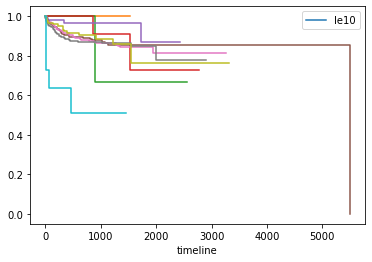

In [36]:
le10 = df1[(df1['age_min_Group'] == '<=10') & (df1['LUNG']==1)]
_11to20 = df1[(df1['age_min_Group'] == '11-20') & (df1['LUNG']==1)]
_21to30 = df1[(df1['age_min_Group'] == '21-30') & (df1['LUNG']==1)]
_31to40 = df1[(df1['age_min_Group'] == '31-40') & (df1['LUNG']==1)]
_41to50 = df1[(df1['age_min_Group'] == '41-50') & (df1['LUNG']==1)]
_51to60 = df1[(df1['age_min_Group'] == '51-60') & (df1['LUNG']==1)]
_61to70 = df1[(df1['age_min_Group'] == '61-70') & (df1['LUNG']==1)]
_71to80 = df1[(df1['age_min_Group'] == '71-80') & (df1['LUNG']==1)]
_81to90 = df1[(df1['age_min_Group'] == '81-90') & (df1['LUNG']==1)]
_91to100 = df1[(df1['age_min_Group'] == '91-100') & (df1['LUNG']==1)]

kmf_0 = KaplanMeierFitter() 
kmf_1 = KaplanMeierFitter() 
kmf_2 = KaplanMeierFitter() 
kmf_3 = KaplanMeierFitter() 
kmf_4 = KaplanMeierFitter() 
kmf_5 = KaplanMeierFitter() 
kmf_6 = KaplanMeierFitter() 
kmf_7 = KaplanMeierFitter() 
kmf_8 = KaplanMeierFitter() 
kmf_9 = KaplanMeierFitter() 

kmf_0.fit(durations = le10['diagnosis_days_min'], event_observed = le10['dead'], label = 'le10')
kmf_1.fit(durations = _11to20['diagnosis_days_min'], event_observed = _11to20['dead'], label = '_11to20')
kmf_2.fit(durations = _21to30['diagnosis_days_min'], event_observed = _21to30['dead'], label = '_21to30')
kmf_3.fit(durations = _31to40['diagnosis_days_min'], event_observed = _31to40['dead'], label = '_31to40')
kmf_4.fit(durations = _41to50['diagnosis_days_min'], event_observed = _41to50['dead'], label = '_41to50')
kmf_5.fit(durations = _51to60['diagnosis_days_min'], event_observed = _51to60['dead'], label = '_51to60')
kmf_6.fit(durations = _61to70['diagnosis_days_min'], event_observed = _61to70['dead'], label = '_61to70')
kmf_7.fit(durations = _71to80['diagnosis_days_min'], event_observed = _71to80['dead'], label = '_71to80')
kmf_8.fit(durations = _81to90['diagnosis_days_min'], event_observed = _81to90['dead'], label = '_81to90')
kmf_9.fit(durations = _91to100['diagnosis_days_min'], event_observed = _91to100['dead'], label = '_91to100')

kmf_0.plot(ci_show=False)
kmf_1.plot(ci_show=False)
kmf_2.plot(ci_show=False)
kmf_3.plot(ci_show=False)
kmf_4.plot(ci_show=False)
kmf_5.plot(ci_show=False)
kmf_6.plot(ci_show=False)
kmf_7.plot(ci_show=False)
kmf_8.plot(ci_show=False)
kmf_9.plot(ci_show=False)


In [37]:
print(kmf_0.predict(1100))
print(kmf_1.predict(1100))
print(kmf_2.predict(1100))
print(kmf_3.predict(1100))
print(kmf_4.predict(1100))
print(kmf_5.predict(1100))
print(kmf_6.predict(1100))
print(kmf_7.predict(1100))
print(kmf_8.predict(1100))
print(kmf_9.predict(1100))

1.0
1.0
0.6666666666666666
0.9090909090909092
0.9669829222011375
0.862822970070568
0.8621221267877462
0.8660199676609087
0.8858811704582938
0.509090909090909


In [38]:
print('Thus, <10 and 10-20 age group has the highest survival for lung cancer at the end of the study.')

Thus, <10 and 10-20 age group has the highest survival for lung cancer at the end of the study.


### 4.17 what is the survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis? 

In [39]:
_61to70 = df1[(df1['age_min_Group'] == '61-70') & (df1['MELANOMA']==1)]

df_61to70_live = _61to70.loc[_61to70['dead'] == 0]
print('live num:', df_61to70_live.shape[0])
df_61to70_dead = _61to70.loc[_61to70['dead'] == 1]
print('dead num:', df_61to70_dead.shape[0])

df_61to70_live['diagnosis_days_m'] = (datetime(2016,8,25) - df_61to70_live['MELANOMA_DT']).astype('timedelta64[D]')
df_61to70_dead['diagnosis_days_m'] = (df_61to70_dead['DEATH_DATE_off'] - df_61to70_dead['MELANOMA_DT']).astype('timedelta64[D]')

df_61to70_me = pd.concat([df_61to70_live,df_61to70_dead])
print('final df:',df_61to70_me.shape[0])

kmf_6 = KaplanMeierFitter() 

kmf_6.fit(durations = df_61to70_me['diagnosis_days_m'], event_observed = df_61to70_me['dead'], label = '_61to70')

print(kmf_6.predict(1825))

live num: 72
dead num: 2
final df: 74
0.9717628075837025


### 4.18 what is the survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis?

In [40]:
_21to30 = df1[(df1['age_min_Group'] == '21-30') & (df1['PANCREAS']==1)]

df_21to30_live = _21to30.loc[_21to30['dead'] == 0]
print('live num:', df_21to30_live.shape[0])
df_21to30_dead = _21to30.loc[_21to30['dead'] == 1]
print('dead num:', df_21to30_dead.shape[0])

df_21to30_live['diagnosis_days_p'] = (datetime(2016,8,25) - df_21to30_live['PANCREAS_DT']).astype('timedelta64[D]')
df_21to30_dead['diagnosis_days_p'] = (df_21to30_dead['DEATH_DATE_off'] - df_21to30_dead['PANCREAS_DT']).astype('timedelta64[D]')

df_21to30_pa = pd.concat([df_21to30_live,df_21to30_dead])
print('final df:',df_21to30_pa.shape[0]) 

kmf_21to30_pa = KaplanMeierFitter() 

kmf_21to30_pa.fit(durations = df_21to30_pa['diagnosis_days_p'], event_observed = df_21to30_pa['dead'], label = '21to30_pa')

print(kmf_21to30_pa.predict(365))


live num: 4
dead num: 1
final df: 5
0.8


### 4.19 what is the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis?

In [41]:
_51to60 = df1[(df1['age_min_Group'] == '51-60') & (df1['THYROID']==1)]

df_51to60_live = _51to60.loc[_51to60['dead'] == 0]
print('live num:', df_51to60_live.shape[0])
df_51to60_dead = _51to60.loc[_51to60['dead'] == 1]
print('dead num:', df_51to60_dead.shape[0])

df_51to60_live['diagnosis_days_t'] = (datetime(2016,8,25) - df_51to60_live['THYROID_DT']).astype('timedelta64[D]')
df_51to60_dead['diagnosis_days_t'] = (df_51to60_dead['DEATH_DATE_off'] - df_51to60_dead['THYROID_DT']).astype('timedelta64[D]')

df_51to60_th = pd.concat([df_51to60_live,df_51to60_dead])
print('final df:',df_51to60_th.shape[0]) 

kmf_51to60_th = KaplanMeierFitter() 

kmf_51to60_th.fit(durations = df_51to60_th['diagnosis_days_t'], event_observed = df_51to60_th['dead'], label = '51to60_th')

print(kmf_51to60_th.predict(2200))


live num: 158
dead num: 2
final df: 160
0.9736842105263158


### 4.20 which race has the high survival for all cancers after 2500 days since diagnosis?

In [42]:
White = df1[df1['race'] == 'White']
African_American = df1[df1['race'] == 'African-American']
Asian_Mideast_Indian = df1[df1['race'] == 'Asian/Mideast-Indian']
Others = df1[df1['race'] == 'Others']

kmf_White = KaplanMeierFitter() 
kmf_African_American = KaplanMeierFitter() 
kmf_Asian_Mideast_Indian = KaplanMeierFitter() 
kmf_Others = KaplanMeierFitter()  

kmf_White.fit(durations = White['diagnosis_days_min'], event_observed = White['dead'], label = 'White')
kmf_African_American.fit(durations = African_American['diagnosis_days_min'], event_observed = African_American['dead'], label = 'African_American')
kmf_Asian_Mideast_Indian.fit(durations = Asian_Mideast_Indian['diagnosis_days_min'], event_observed = Asian_Mideast_Indian['dead'], label = 'Asian_Mideast_Indian')
kmf_Others.fit(durations = Others['diagnosis_days_min'], event_observed = Others['dead'], label = 'Others')

print(kmf_White.predict(2500))
print(kmf_African_American.predict(2500))
print(kmf_Asian_Mideast_Indian.predict(2500))
print(kmf_Others.predict(2500))


0.926329054287702
0.7417672337041542
0.923486855555039
0.9236054744999834


In [43]:
print('White race has the high survival for all cancers after 2500 days.')

White race has the high survival for all cancers after 2500 days.
